# LCA for different transport modes with a focus on bicycles

The notebook calculates the life cycle impacts for the EDGE_T internalization.
* Calculate the energy requirement of powering bicycles
* Calculate the impact of nutrition
* Calculate the LCA impact of transport modes in EDGE_T
* Add literature impacts of transport modes in EDGE_T
* Output monetized impacts for EDGE_T internalization

In [2]:
#to-does:

# directly connect to carculator for the LCA processes to get different sizes and noise
# small scale version is to ask A for different sizes

# ebikes
## first add a couple of new bicycle processes that are a mix of cycles and ebikes
## big solution is to include ebikes into edget

# adjust preferance factor of non-motorized when ebikes are added 
# they should develop more like motorscooter?





In [3]:
# known issues

# LCA impacts are vehicle fleet averages, not differentiated really by LDV type, does favour big SUVs because load factor adjustment?
#  -> couple with carculator outputs

# carculator also delivers noise data

#liquids is only mapped to gasoline not diesel, bus is mapped to diesel
# buses assume EURO 6, only CH activity available

# we only consider person transport
# differentiate or add surrogate truck (eg.40t) for freight to get per vkm and add to all road processes

# plastic tire emissions not considered in cost


In [4]:
# fire up a connected console
%qtconsole

In [5]:
import pickle
pickle.HIGHEST_PROTOCOL = 4
import pandas as pd
import numpy as np
import math as ma
import warnings
import matplotlib.pyplot as plt

import pprint
import brightway2 as bw
import bw2io
import seaborn as sn
import json

%run -i ./script/helpers.py


warnings.filterwarnings('ignore')

###### run LCA script for a couple of years and interpolate in between

year = 2030
#we only read contemporary bus data so far
bus_year = 2020

db_name = "ecoinvent_remind_Budg1100_ElecPush"
db_name_buses = "Mobitool - buses"


scenario = "bike-lca_lca_Budg1100_ElecPush"

# xxxx change to elecera plus lifestyle


#LCA database, REMIND, MAGPIE and air pollution data
remind_report        = "data\\remind\\Budg1100_ElecEra_2020-09-17_17.17.49\\REMIND_generic_Budg1100_ElecEra_withoutPlus.mif"
lca_database         = "data\\lca\\brightway2-project-bike-lca_lca_Budg1100_ElecPush-backup.22-January-2021-08-54PM.tar.gz"
magpie_report        = "data\\magpie\\magpie_C_SDP-PkBudg1100-mag-4.mif"
literature_report    = "data\\bicycles_rule_plot_source.csv"
air_pollution_report = "data\\air_pollution\\results_dalys_SSP2_Budg1100_ElecEra_SSP2_IIASA_aneris_downscaling_.csv"
region_mapping_path  = "data\\regionmappingH12.csv"

#EDGE_T data
edgetransport_moto_path       = "data\\edgeTransport\\UCD_NEC_iso.csv"
edgetransport_non_moto_path   = "data\\edgeTransport\\price_nonmot.csv"
edgetransport_load_factor_path= "data\\edgeTransport\\loadFactor.csv"

#Global Burden of Disease data
GBD_path             = "data\\GBD\\GBD.json"

gbd_location_mapping_path = "data\\GBD\\location_mapping.csv"
gbd_measure_mapping_path  = "data\\GBD\\measure_mapping.csv"
gbd_rei_mapping_path      = "data\\GBD\\rei_mapping.csv"
gbd_cause_mapping_path    = "data\\GBD\\cause_mapping.csv"
gbd_metric_mapping_path   = "data\\GBD\\metric_mapping.csv"

#Monetization

vsl_coeff_path            = "data\\monetization\\vsl_coeff.csv"


noise_eea_paths           = "data\\noise\\EEA_noise.csv"

#Carculator export

carculator_bus_path       = "data\\carculator\\buses_bw_ei_371.xlsx"

In [6]:
# read REMIND energy results
remind = pd.read_csv(remind_report, sep=';')

In [7]:
# read REMIND adjusted lci
bw.restore_project_directory(lca_database)
bw.projects.set_current(scenario)
bw.databases


Restoring project backup archive - this could take a few minutes...


Databases dictionary with 8 object(s):
	biosphere3
	ecoinvent 3.7 cutoff
	ecoinvent_remind_Budg1100_ElecPush_2020
	ecoinvent_remind_Budg1100_ElecPush_2025
	ecoinvent_remind_Budg1100_ElecPush_2030
	ecoinvent_remind_Budg1100_ElecPush_2035
	ecoinvent_remind_Budg1100_ElecPush_2040
	ecoinvent_remind_Budg1100_ElecPush_2050

In [8]:
# read carculator bus specific LCI if not yet in databases
db = db_name_buses
if db not in bw.databases:
    ei_bus = bw2io.importers.excel.ExcelImporter(carculator_bus_path)
    ei_bus.apply_strategies()
    ei_bus.match_database(fields=["name", "unit", "location"])
    ei_bus.match_database(str(db_name) + "_" + str(year))
    ei_bus.add_unlinked_flows_to_biosphere_database()

    ei_bus.write_database()
ei_bus =  bw.Database(str(db_name_buses))

Extracted 1 worksheets in 117.33 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.48 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Vacuuming database 


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


Title: Writing activities to SQLite3 database:
  Started: 11/02/2021 15:28:07
  Finished: 11/02/2021 15:28:09
  Total time elapsed: 00:00:02
  CPU %: 14.70
  Memory %: 3.84
Applying strategy: link_iterable_by_fields


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Title: Writing activities to SQLite3 database:
  Started: 11/02/2021 15:29:42
  Finished: 11/02/2021 15:29:44
  Total time elapsed: 00:00:01
  CPU %: 51.30
  Memory %: 3.86
Created database: Mobitool - buses


In [9]:
ei = bw.Database(str(db_name) + "_" + str(year))

In [10]:
#transport, passenger car, fleet average, {BEV, FCEV, ICEV-d, ICEV-p, ICEV-g, HEV-d, HEV-p, HEV-g, PHEV-d, PHEV-p, PHEV-g}, <year>, -d = Diesel, -p = Petrol, -g = Gas
#ES|Transport|VKM|Pass|Road|LDV|{BEV, FCEV, Gases, Hybrid Electric, Hybrid Liquids, Liquids}

### Calculation of kcal/km bicycle

The energy requirements of a bicycle are mainly determined by the gravity, rolling recistance, mechanic loss and, most importantly, aerodynamic drag.

slope assumed to be zero since commutes begin and end at the same elevation.
$\qquad F_{\mbox{gravity}} = g0 \sin(\arctan(\frac{s}{100})) w = 0 \\
\text{where $g0$ = gravitational acceleration, $s$ = slope and $w$ = weight of rider and bike}$ 

rolling resistance
$\qquad F_{\mbox{rolling}} = g0 \cos(\arctan(\frac{s}{100})) w c_{r} \\
\text{where $c_r$ = coefficient of rolling resistance}$

Aerodynamic drag
$\qquad F_{\mbox{aero}} = 0.5 c_{d} A \rho V^2 \\
\text{where $c_{d}$ = drag coefficient, $A$ = frontal area, $\rho$= air density and $V$ is speed}$

Power supply by rider:
$\qquad P_{\mbox{rider}} = c_{b} \left[F_{\mbox{gravity}} + F_{\mbox{rolling}} + F_{\mbox{aero}}\right] V \\
\text{where $c_{b}$ = bike efficiency, drivetrain losses and others}$

Food intake:
$\qquad E_{rider} = (P_{\mbox{rider}} \frac{d}{V}) \frac{1}{c_{m}} \\
\text{where $d$ = distance, $c_{m}$ is the muscular efficiency}$ 


do we need to give sources for formulas, they seem quite obvious

Take Frontal Area and Drag Coeff from 
https://www.researchgate.net/publication/51660070_Aerodynamic_drag_in_cycling_Methods_of_assessment/link/00b49517f886174690000000/download

Muscular efficiency:
https://www.researchgate.net/publication/22014772_Muscular_efficiency_during_steady-rate_exercise_effects_of_speed_and_work_rate

This gives around 15 kcal


In [11]:
ws2kcal = 1/4184
g0 = 9.8067 # m/s2
roh = 1.22601 # kg/m3

s = 0 # %
w = 75 # kg
a = 0.5 # m2

v = 4.16 # m/2 #15kmh from EDGE-T
d = 1000 # m

cr = 0.005
cd = 0.9
cb = 0.08
cm = 0.2


E_cycling = (((1-cb)*((g0*ma.sin(ma.atan(s/100))*w)+(g0*ma.cos(ma.atan(s/100))*w*cr)+(0.5*cd*a*roh*pow(v,2)))*v)*d/v)*1/cm * ws2kcal

print("{:.2f} kcal/km of food intake required for cycling 1km".format(E_cycling))

#see https://www.fitness-gesundheit.uni-wuppertal.de/fileadmin/fitness-gesundheit/pdf-Dokumente/Publikationen/2013/WasistMET_S.82-83.pdf
MET_minutes_cycling = E_cycling/1.2  
print("{:.2f} MET minutes required for cycling 1km".format(MET_minutes_cycling))

9.29 kcal/km of food intake required for cycling 1km
7.74 MET minutes required for cycling 1km


In [12]:
# Add walking
# 

######### find good source of low kcal here. do the food requirements not outweight some effects
#check the environemntal cost

## decide what nutrition requirement is associated with walking one km
### simple approach is to use 75kcal as a good estimate for a body weight of 75kg according to the source below
E_walking = 75
MET_minutes_walking = E_walking/1.2 
print("{:.2f} kcal/km of food intake required for walking 1km".format(E_walking))
print("{:.2f} MET minutes required for walking 1km".format(MET_minutes_walking))

### elaborate appraoch would be to use:
#### take the regression model from https://journals.lww.com/nsca-jscr/Fulltext/2010/10000/Comparison_of_Energy_Expenditure_to_Walk_or_Run_a.29.aspx
#### read the kg average body weight from magpie and apply to this formula
#####E_walking = (mass (kg) × 0.789 - gender (men = 1, women = 2) × 7.634 + 51.109) / 1.6


75.00 kcal/km of food intake required for walking 1km
62.50 MET minutes required for walking 1km


### Diet to fuel cycling and ebike

The diet plays a crucial role for the impact of bicycles. We model the nutrition demand and supply with the MAGPIE model. We use the same climate budget and assume a EAT-LANCET low waste diet adoption until 2050.

In [13]:
# Calculate a kcal share mix according to the MAGPIE results
# Calculate a demand/supply share
# Calulate the lca for that
cal2kj = 4.184

#select which nutrition processes are included
#determine their kg/kcal
#see
%run -i ./script/diet_mappings.py

In [14]:
# fill a list with activities present in the magpie_ecoinvent_nutrition_mapping_simple
activities=[]
for value in magpie_ecoinvent_nutrition_mapping_extended.values():
        activities.append([act for act in ei if act['name']==str(value).split("'",2)[1] and 'GLO' in act['location']][0])

#create a new nutrition activity for the 
nutrition = ei.new_activity(code = 'nutrition', name = "Nutrition mix, EAT-Lancet diet convergance in 2050", unit = "kcal")

print("the nutrition consists of:")

#loop over included nutition activities and add amount
for i in range(len(activities)-1):
    act= str(activities[i])
    print(act)

    amt = magpie_intake.query("Variable == @act")[str(year)]
    amt = pd.to_numeric(amt, errors='coerce')
    if(ma.isnan(amt.values[0])):
        amt.values[0] = 0
    print(amt.values[0])

    nutrition.new_exchange(input=activities[i].key,amount=amt.values[0],unit="kg/kcal",type='technosphere').save()

nutrition.save()


the nutrition consists of:
'market for fishmeal, 65-67% protein' (kilogram, GLO, None)
6.9908745247148295e-06
'market for maize seed, organic, at farm' (kilogram, GLO, None)
1.0389942877763694e-05
'market for rice, non-basmati' (kilogram, GLO, None)
0.00010836388157680935
'market for wheat grain, feed' (kilogram, GLO, None)
3.908248216903998e-05
'market for peanut' (kilogram, GLO, None)
7.664178754166081e-06
'market for apple' (kilogram, GLO, None)
0.00013447994865295248
'market for potato' (kilogram, GLO, None)
2.00564032503196e-05
'market for chickpea' (kilogram, GLO, None)
1.0348285396870104e-05
'market for potato' (kilogram, GLO, None)
2.00564032503196e-05
'market for sugar beet pulp' (kilogram, GLO, None)
5.109008557589333e-09
'market for sugar, from sugarcane' (kilogram, GLO, None)
2.162297378427056e-07
'market for dairy' (cubic meter, GLO, None)
1.5234767913888427e-07
'chicken production' (kilogram, GLO, None)
1.1301904685935106e-05
'market for swine for slaughtering, live weigh

In [15]:
# Add new process which reflects the nutrition requirement of walking
walking = ei.new_activity(code = 'walking, energy requirements', name = "walking", unit = "pkm")

walking.new_exchange(input=nutrition,amount=E_walking,unit="kcal",type='technosphere').save()

walking.save()

### Transport modes to perform LCA on

In [16]:
#transport modes to perform lca on
ecoinvent_activity_transport =        ["transport, passenger car, fleet average, BEV, "  + str(year),
                                       "transport, passenger car, fleet average, FCEV, "   + str(year),
                                       "transport, passenger car, fleet average, ICEV-g, "   + str(year),
                                       "transport, passenger car, fleet average, PHEV-p, "   + str(year),
                                       "transport, passenger car, fleet average, HEV-p, "   + str(year),
                                       "transport, passenger car, fleet average, ICEV-p, "   + str(year),
                                       "market for transport, passenger train", 
                                       "market for transport, passenger, motor scooter",
                                       "market for transport, passenger, bicycle",
                                       "market for transport, passenger, electric bicycle",
                                       "market for transport, passengers, aircraft, short haul",
                                       "market for transport, passengers, aircraft, long haul",
                                       "walking"]

#bus transport modes
ecoinvent_activity_transport_bus = ["transport, passenger bus, battery electric - overnight charging, NCA battery, 18m articulated urban bus, " + str(bus_year),
                                    "transport, passenger bus, fuel cell electric, 18m articulated urban bus, " + str(bus_year),
                                    "transport, passenger bus, diesel, 18m articulated urban bus, "+ str(bus_year) +", EURO-VI",
                                    "transport, passenger bus, compressed gas, 18m articulated urban bus, "+ str(bus_year) +", EURO-VI"]

In [17]:
# fill a list with the relevant ecoinvent activities
# use the updated ecoinvent for cars and others
# use the bus database for buses
acti = {}

for i in range(len(ecoinvent_activity_transport)):
    activity = str(ecoinvent_activity_transport[i])
    print(activity)
    
    acti[activity] = [act for act in ei if activity in act["name"]]
    
# fill a list with the relevant ecoinvent activities
acti_bus = {}

for i in range(len(ecoinvent_activity_transport_bus)):
    activity_bus = str(ecoinvent_activity_transport_bus[i])
    print(activity)
    
    acti_bus[activity_bus] = [act for act in ei_bus if activity_bus in act["name"]]

#merge the two    
acti = {**acti, **acti_bus}   

transport, passenger car, fleet average, BEV, 2030
transport, passenger car, fleet average, FCEV, 2030
transport, passenger car, fleet average, ICEV-g, 2030
transport, passenger car, fleet average, PHEV-p, 2030
transport, passenger car, fleet average, HEV-p, 2030
transport, passenger car, fleet average, ICEV-p, 2030
market for transport, passenger train
market for transport, passenger, motor scooter
market for transport, passenger, bicycle
market for transport, passenger, electric bicycle
market for transport, passengers, aircraft, short haul
market for transport, passengers, aircraft, long haul
walking
walking
walking
walking
walking


In [18]:
# calculate the lci and lca for the activities in acti

# for LDV transfer kilometer to person kilometer
# for bikes and ebikes add nutrition

lca = {}
impact_category = ('IPCC 2013', 'climate change', 'GWP 100a')
for i in acti:
  
        for e in acti[i]:

            lca[e] = bw.LCA({e: 1}, (impact_category))
            lca[e].lci()
            lca[e].lcia()
            lca[e].score
            print(str(e) + ': '+  str(lca[e].score) + ' ' + str(impact_category))



'transport, passenger car, fleet average, BEV, 2030' (kilometer, NEU, None): 0.09718413182456287 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, BEV, 2030' (kilometer, CAZ, None): 0.1066398894480377 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, BEV, 2030' (kilometer, OAS, None): 0.1762302427396646 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, BEV, 2030' (kilometer, CHA, None): 0.1360804071481436 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, BEV, 2030' (kilometer, MEA, None): 0.1501523697982392 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, BEV, 2030' (kilometer, IND, None): 0.1809728732949885 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, BEV, 2030' (kilometer, SSA, None): 0.11994160887877246 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passen

'transport, passenger car, fleet average, HEV-p, 2030' (kilometer, USA, None): 0.2582337538658594 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, HEV-p, 2030' (kilometer, SSA, None): 0.21463341709390965 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, ICEV-p, 2030' (kilometer, OAS, None): 0.27319475366472323 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, ICEV-p, 2030' (kilometer, MEA, None): 0.2658161125001372 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, ICEV-p, 2030' (kilometer, LAM, None): 0.26828630733177083 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, ICEV-p, 2030' (kilometer, EUR, None): 0.2873357267416619 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, ICEV-p, 2030' (kilometer, IND, None): 0.263602009213699 ('IPCC 2013', 'climate change', 'GWP 100a')

In [19]:
# calculate the lci and lca for the activities in acti

# for LDV transfer kilometer to person kilometer
# for bikes and ebikes add nutrition

lca = {}
impact_category = ('IPCC 2013', 'climate change', 'GWP 100a')
for i in acti:
  
        for e in acti[i]:
            lca[e] = bw.LCA({e: 1}, (impact_category))
            
            if 'car' in str(e):
                lca[e] = bw.LCA({e: 1}, (impact_category))
                
            if 'passenger, bicycle' in e:
                lca[e] = bw.LCA({e: 1, nutrition: E_cycling}, (impact_category))   
        
                # this nutrition requirement is only an estimate, find better source
            if 'passenger, electric bicycle' in e:
                lca[e] = bw.LCA({e: 1, nutrition: 5}, (impact_category)) 

            lca[e].lci()
            lca[e].lcia()
            lca[e].score
            print(str(e) + ': '+  str(lca[e].score) + ' ' + str(impact_category))



'transport, passenger car, fleet average, BEV, 2030' (kilometer, NEU, None): 0.09718413182456287 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, BEV, 2030' (kilometer, CAZ, None): 0.1066398894480377 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, BEV, 2030' (kilometer, OAS, None): 0.1762302427396646 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, BEV, 2030' (kilometer, CHA, None): 0.1360804071481436 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, BEV, 2030' (kilometer, MEA, None): 0.1501523697982392 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, BEV, 2030' (kilometer, IND, None): 0.1809728732949885 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, BEV, 2030' (kilometer, SSA, None): 0.11994160887877246 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passen

'transport, passenger car, fleet average, HEV-p, 2030' (kilometer, USA, None): 0.2582337538658594 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, HEV-p, 2030' (kilometer, SSA, None): 0.21463341709390965 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, ICEV-p, 2030' (kilometer, OAS, None): 0.27319475366472323 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, ICEV-p, 2030' (kilometer, MEA, None): 0.2658161125001372 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, ICEV-p, 2030' (kilometer, LAM, None): 0.26828630733177083 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, ICEV-p, 2030' (kilometer, EUR, None): 0.2873357267416619 ('IPCC 2013', 'climate change', 'GWP 100a')
'transport, passenger car, fleet average, ICEV-p, 2030' (kilometer, IND, None): 0.263602009213699 ('IPCC 2013', 'climate change', 'GWP 100a')

In [20]:
# plotting data preperation

def modes(lca):
    lca_impacts = {}
    fd   = pd.DataFrame()



    for i in lca:
      
        for m in methods:
        
            lca[i].switch_method(m)    
            lca[i].lcia()
            lca_impacts[m[2]] = lca[i].score

            
        full = pd.DataFrame.from_dict(lca_impacts, orient="index",  columns=[str(i)])
        fd[str(i)]=full[str(i)]
        
        fd.index.name = "indicator"
        fd.columns.name = "transport mode"
    return fd

In [21]:
methods = [m for m in bw.methods if "ReCiPe Endpoint (H) V1.13', 'ecosystem quality" in str(m) or "ReCiPe Endpoint (H) V1.13', 'human health" in str(m) or "ReCiPe Endpoint (H) V1.13', 'resources" in str(m)]
methods

[('ReCiPe Endpoint (H) V1.13', 'human health', 'human toxicity'),
 ('ReCiPe Endpoint (H) V1.13', 'human health', 'climate change'),
 ('ReCiPe Endpoint (H) V1.13', 'human health', 'ionising radiation'),
 ('ReCiPe Endpoint (H) V1.13', 'human health', 'ozone depletion'),
 ('ReCiPe Endpoint (H) V1.13', 'human health', 'particulate matter formation'),
 ('ReCiPe Endpoint (H) V1.13',
  'human health',
  'photochemical oxidant formation'),
 ('ReCiPe Endpoint (H) V1.13', 'ecosystem quality', 'marine ecotoxicity'),
 ('ReCiPe Endpoint (H) V1.13', 'ecosystem quality', 'terrestrial ecotoxicity'),
 ('ReCiPe Endpoint (H) V1.13',
  'ecosystem quality',
  'agricultural land occupation'),
 ('ReCiPe Endpoint (H) V1.13', 'ecosystem quality', 'climate change'),
 ('ReCiPe Endpoint (H) V1.13',
  'ecosystem quality',
  'freshwater eutrophication'),
 ('ReCiPe Endpoint (H) V1.13', 'ecosystem quality', 'marine eutrophication'),
 ('ReCiPe Endpoint (H) V1.13',
  'ecosystem quality',
  'natural land transformation'

In [22]:
data = modes(lca)

data.to_csv("results/impact_pkm_"+str(year)+".csv")

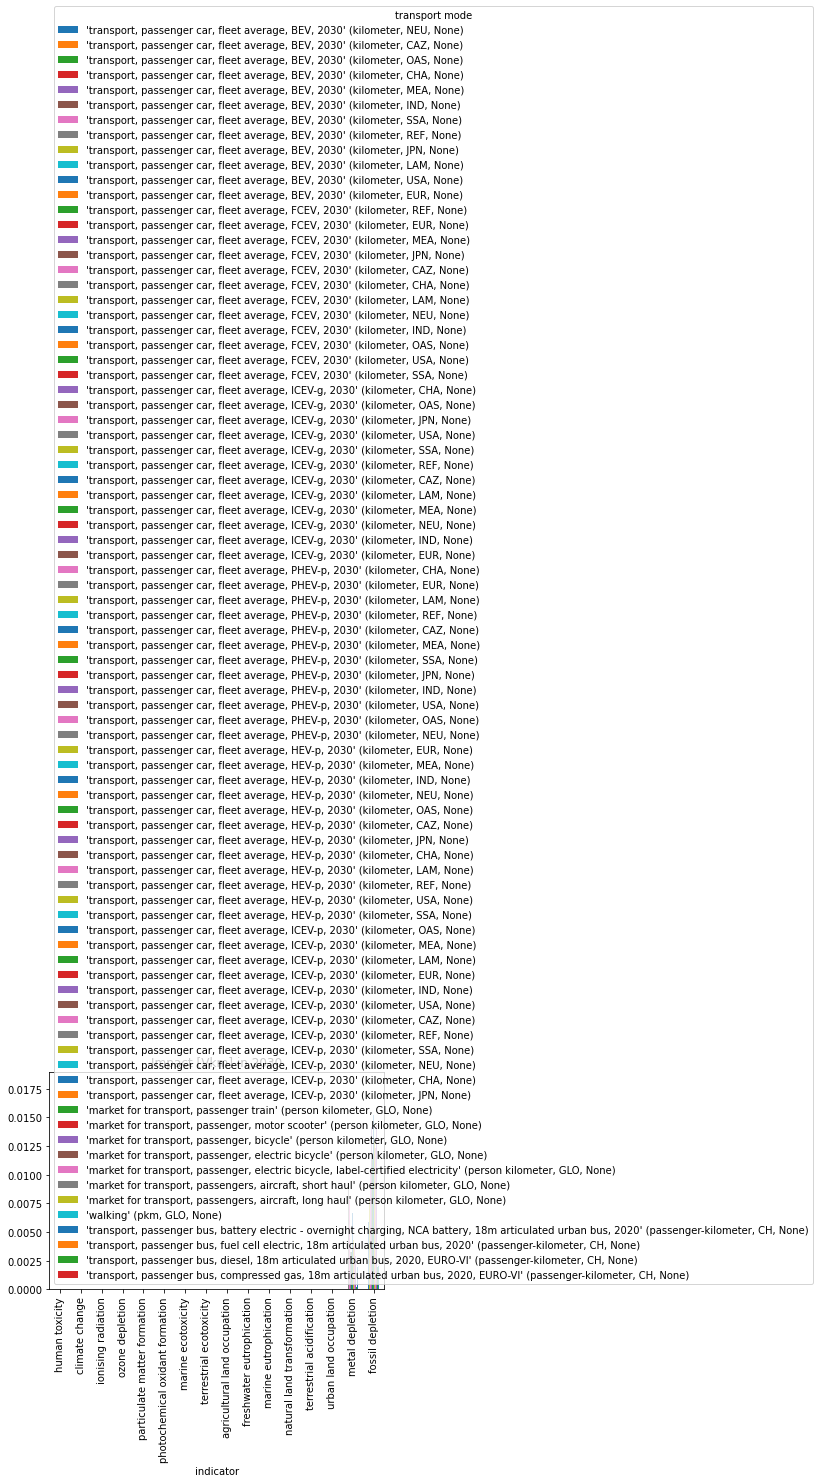

In [23]:
data.plot.bar()
plt.title('Impact [Vkm] in ' + str(year))
plt.savefig("plot/impact_pkm_"+str(year)+".pdf", bbox_inches='tight')

In [25]:
# calculate the air pollution of the relevant sectors LDV pass road and bus
air_pollution = pd.read_csv(air_pollution_report, sep=';')
%run -i ./script/air_pollution_inter.py
#data['transport mode'] = data['transport mode'].astype(str).str.split("\'").str[1]


NameError: name 'years' is not defined

In [ ]:
# read in EDGE_results and for moto and non-moto

edgetransport_moto     = pd.read_csv(edgetransport_moto_path, sep=',')
edgetransport_non_moto = pd.read_csv(edgetransport_non_moto_path, sep=',')

edgetransport_moto     = edgetransport_moto[['year','region','vehicle_type', 'technology','non_fuel_price']]
edgetransport_non_moto = edgetransport_non_moto[['year','region','subsector_L3', 'technology','tot_price']]

edgetransport_moto = edgetransport_moto.rename(columns={"year":"period",'non_fuel_price':'cost'})
edgetransport_non_moto = edgetransport_non_moto.rename(columns={"year":"period",'subsector_L3':'vehicle_type','tot_price':'cost'})

edgetransport = edgetransport_moto.append(edgetransport_non_moto)

edgetransport['vehicle_type_technology'] = edgetransport['vehicle_type'].astype('string') + '_' + edgetransport['technology'].astype('string')

In [ ]:
                                  
# read the edge transnsport output  

%run -i ./script/mappings.py


#ultimately we need lca impact for edgetransport
# map edgetransport to LCA processes
edgetransport['LCA'] = edgetransport['vehicle_type_technology'].map(edge_internalization_mapping_detailed_LCA)





# then merge data to edgetransport
edgetransport_LCA = edgetransport.merge(data, left_on=['region','period', 'LCA'], right_on=['region','period','transport mode'], how='left')


###check it and iron out mistakes

# why is the bus processes missing? because its GLO
# filter NAN and merge with GLO processes without considering region

edgetransport_GLO = edgetransport.loc[edgetransport['LCA'].isin(data.loc[data['region'] == 'GLO']['transport mode'].unique())]

# adjust the global stuff??! with some proxy?

#take global values where region values are not available
edgetransport_GLO = edgetransport_GLO.merge(data.loc[data['region'] == 'GLO'], left_on=['period', 'LCA'], right_on=['period','transport mode'], how='left')

#edgetransport_GLO
edgetransport_GLO = edgetransport_GLO.drop(columns=['region_y'])
edgetransport_GLO = edgetransport_GLO.rename(columns={"region_x": "region"})


edgetransport_out = pd.concat([edgetransport_LCA,edgetransport_GLO])

# better version

# regional
## aggregate country processes to REMIND regions, take weighted averages
## if regional inventories are missing use GLO data

### do this here





In [ ]:
# adjust the lca results to below
#consolidate columns
edgetransport_out = edgetransport_out.drop(columns=['transport mode'])
#,'GDP_scenario', 'EDGE_scenario',  'year'

# drop climate change here because we already capture it in the model with the CO2 price
# drop air pollution because we capture it with the more deatiled air pollution model
# drop cost from edgetransport
edgetransport_out = edgetransport_out.drop(columns=['cost','air_pollution_DALY','air_pollution_death','climate change','photochemical oxidant formation'])


# there are some duplicates with NAs, drop, not sure why
edgetransport_out = edgetransport_out.dropna()

# from wide to long
# include loadfactor only here and not above

edgetransport_out = pd.melt(edgetransport_out, id_vars=['region','period','vehicle_type','technology','vehicle_type_technology','LCA'],
        var_name="impact_category", 
        value_name="cost")

edgetransport_LCA = edgetransport_out




# Calc indicators from literature



In [ ]:
# this is the literature review of non-LCA impacts
literature = pd.read_csv(literature_report, sep=';')

#literature
#%run -i ./script/lit_inter.py

## we consider Road accidents, benfits from physical activity, noise  (health effets) and tire wear 

### Road accidents is based on the Global burden of disease (http://ghdx.healthdata.org/gbd-results-tool?params=gbd-api-2019-permalink/f50245689196c894965621f48bf542fd)
### Physical activity is based on the Global burden of disease and \cite{Lear2017}
### Noise is based on \cite{EuropeanEnvironmentAgency2020}

### Microplastics from tire wear is based on \cite{Evangeliou2020}




In [ ]:
# load the GBD data and join it with mappings
%run -i ./script/load_gbd.py

# low physical activity
%run -i ./script/low_physical_activity.py
df_low
#rename value and unit for all of them
df_low =df_low.rename(columns={"value": "Value_low", "Unit": "Unit_low"})

# physical activity impacts are benefits
df_low['Value_low']= df_low['Value_low'] * -1


# assigne the benefit to bicycles and walking depending on their MET per pkm

# road safety
%run -i ./script/road_safety.py
df_acc_remind
df_acc_remind =df_acc_remind.rename(columns={"value": "Value_acc", "Unit": "Unit_acc", "year": "Period", "remind": "Region"})



# noise
%run -i ./script/noise.py
df_noise
df_noise =df_noise.rename(columns={"value": "Value_noise", "Unit": "Unit_noise", "year": "Period", "remind": "Region"})

# tire wear use this in the total processing
%run -i ./script/tire_wear.py
remind_tire['Variable'] = 'Plastic emissions tires'
remind_tire =remind_tire.rename(columns={"value": "Value_tire_plastic", "Unit": "Unit_tire_plastice"})
remind_tire = remind_tire.drop(columns=['Region'])

In [ ]:
# check what output format is needed
# then adjust the suff to this format
# read in EDGE_results and for moto and non-moto

#### here there should be duplicates introduced because we do not consider the technology
edgetransport_moto     = pd.read_csv(edgetransport_moto_path, sep=',')
edgetransport_non_moto = pd.read_csv(edgetransport_non_moto_path, sep=',')

edgetransport_moto     = edgetransport_moto[['year','region','vehicle_type','non_fuel_price']]
edgetransport_non_moto = edgetransport_non_moto[['year','region','subsector_L3','tot_price']]

edgetransport_moto = edgetransport_moto.rename(columns={"year":"period", "vehicle_type": "technology",'non_fuel_price':'cost'})
edgetransport_non_moto = edgetransport_non_moto.rename(columns={"year":"period",'subsector_L3':'technology','tot_price':'cost'})

edgetransport = edgetransport_moto.append(edgetransport_non_moto)



edgetransport['technology_low']   = edgetransport['technology'].map(edge_internalization_mapping_low)
edgetransport['technology_acc']   = edgetransport['technology'].map(edge_internalization_mapping_acc)
edgetransport['technology_noise'] = edgetransport['technology'].map(edge_internalization_mapping_noise)
edgetransport['technology_tires'] = edgetransport['technology'].map(edge_internalization_mapping_tire)


In [ ]:
# literautre data is only from 1990 to 2019
# fill here the 2020 to 2100 in step 5 with NA for later interpolation

years = edgetransport['period'].unique()[edgetransport['period'].unique() > 2019]

def add_missing_years(df_in, value_column):

    for x in years:
        df = df_in.loc[df_in['Period'] == 2015]
        df['Period'] = x
        #use this to later interpolate
        #df[value_column] = 'NaN'
        
        
        df_in = pd.concat([df_in,df])
    return df_in

df_low = add_missing_years(df_low, 'Value_low')
df_acc_remind = add_missing_years(df_acc_remind, 'Value_acc')





In [ ]:
#extrapolate to the future years for:
#interpolate stuff here
## this is not doing anything here since the above script already uses 2015 values for every after 2015
def interpolate_missing_years(df_in, value_column, unit_column):

    df_in[value_column] = pd.to_numeric(df_in[value_column], errors='coerce')
    df_in = df_in.pivot(index=['Region','Period',unit_column],columns = 'Variable', values=value_column)
    df_in = df_in.interpolate(method='linear')
    
    return df_in

df_low = interpolate_missing_years(df_low, 'Value_low', 'Unit_low')
df_acc_remind = interpolate_missing_years(df_acc_remind, 'Value_acc', 'Unit_acc')
df_noise = interpolate_missing_years(df_noise, 'Value_noise', 'Unit_noise')

#noise is already kept constant



In [ ]:
df_low.pivot_table(values="Cycling", index="Period", columns="Region").plot()


df_noise.pivot_table(values="Road", index="Period", columns="Region").plot()
df_acc_remind.pivot_table(values="Motor vehicle road injuries", index="Period", columns="Region").plot()
df_acc_remind.pivot_table(values="Cyclist road injuries", index="Period", columns="Region").plot()



In [ ]:
# melt them from wide to long
df_acc_remind=df_acc_remind.reset_index()
df_acc_remind=pd.melt(df_acc_remind, id_vars=['Region','Period','Unit_acc'],
        var_name="Variable", 
        value_name="Value_acc",
        value_vars=['Cyclist road injuries', 'Motor vehicle road injuries','Motorcyclist road injuries'])

df_noise=df_noise.reset_index()
df_noise=pd.melt(df_noise, id_vars=['Region','Period','Unit_noise'],
        var_name="Variable", 
        value_name="Value_noise",
        value_vars=['Aircraft', 'Rail','Road'])

df_low=df_low.reset_index()
df_low=pd.melt(df_low, id_vars=['Region','Period','Unit_low'],
        var_name="Variable", 
        value_name="Value_low",
        value_vars=['Cycling'])

In [ ]:
# put the literauter stuff together with edge transport
edgetransport = edgetransport.merge(remind_tire, left_on=['technology_tires'], right_on=['Variable'], how ='left', suffixes=(False, False))
edgetransport = edgetransport.drop(columns=['Variable'])

edgetransport = edgetransport.merge(df_low, left_on=['period', 'region', 'technology_low'], how ='left', right_on=['Period','Region','Variable'], suffixes=(False, False))
#remove region period and Variable
edgetransport = edgetransport.drop(columns=['Variable','Scenario','Period','Region'])

edgetransport = edgetransport.merge(df_acc_remind, left_on=['period', 'region', 'technology_acc'], how ='left', right_on=['Period','Region','Variable'], suffixes=(False, False))
edgetransport = edgetransport.drop(columns=['Variable','Period','Region'])

edgetransport_lit = edgetransport.merge(df_noise, left_on=['period', 'region', 'technology_noise'], how ='left', right_on=['Period','Region','Variable'], suffixes=(False, False))




In [ ]:
# translate per capita in km
remind_population = remind[remind['Variable'] == 'Population']

remind_population    = remind_population.iloc[:, :-1]

remind_population = pd.melt(remind_population, id_vars=['Model','Scenario','Region' ,'Variable','Unit'], var_name='Period', value_name='value',ignore_index=True)
remind_population['Period'] = remind_population['Period'].astype(int)

edgetransport_lit = edgetransport_lit.merge(remind_population[['Period','Region','value']],  how='left',on = ['Region','Period'])

edgetransport_lit['Value_acc'] = edgetransport_lit['Value_acc'] * edgetransport_lit['value'] * (1*10**6) / (1*10**9)
edgetransport_lit['Unit_acc'] = 'DALY/vkm'
edgetransport_lit['Value_low'] = edgetransport_lit['Value_low'] * edgetransport_lit['value'] * (1*10**6) / (1*10**9)
edgetransport_lit['Unit_low'] = 'DALY/pkm MET'

### need to multiply MET rewuirements of cycling and walking for low physical activity

edgetransport_lit = edgetransport_lit.drop(['value'],axis=1)

edgetransport_lit['Value_noise'] = edgetransport_lit['Value_noise'] / (1*10**9)
edgetransport_lit['Unit_noise'] = 'DALY/vkm'
edgetransport_lit['Value_tire_plastic'] = edgetransport_lit['Value_tire_plastic'] / (1*10**9)
edgetransport_lit['Unit_tire_plastice'] = 'Mt/vkm'

#rename to more clear names
edgetransport_lit = edgetransport_lit.rename(columns={"Value_acc":"Road safety",'Value_low':'Physical Activity', 'Value_noise':'Noise', 'Value_tire_plastic': 'Microplastic tire t'})

#wide to long
##drop some columns
edgetransport_lit = edgetransport_lit.drop(['cost','Model','Unit_tire_plastice','Unit_low','Unit_acc','Region','Period','Unit_noise','technology_low','technology_acc','technology_noise','technology_tires','Variable'],axis=1)

edgetransport_lit = pd.melt(edgetransport_lit, id_vars=['region','period','technology'],
        var_name="impact_category", 
        value_name="cost")

# add vehicle type and vehicle_type_technology columns to fit LCA results
edgetransport_lit['vehicle_type']                 = edgetransport_lit['technology']
edgetransport_lit['vehicle_type_technology'] = edgetransport_lit['technology']



In [ ]:
#merge LCA and literature output
edgetransport_write_out = pd.concat([edgetransport_lit,edgetransport_LCA])

In [ ]:
# use load factor to translate to PKM

## adjust LCA results to pkm with car_load_factor or take the car load factor from edge
edgetransport_load_factor = pd.read_csv(edgetransport_load_factor_path, sep=',')

#merge byedgetransport_lit vegicle type
edgetransport_write_out =  edgetransport_write_out.merge(edgetransport_load_factor, left_on=['period', 'region', 'vehicle_type'], how ='left', right_on=['year','region','vehicle_type'], suffixes=(False, False))

######ebike is missing from load factor

#assigne load factor one to walking and cycling
edgetransport_write_out['loadFactor'][~edgetransport_write_out['vehicle_type'].str.contains('Cycle', na=False)] = 1
edgetransport_write_out['loadFactor'][~edgetransport_write_out['vehicle_type'].str.contains('Walk', na=False)] = 1

# divide by load factor
edgetransport_write_out['cost'] = edgetransport_write_out['cost']/ edgetransport_write_out['loadFactor']

# clean up
edgetransport_write_out = edgetransport_write_out.drop(columns=['year','loadFactor','GDP_scenario','EDGE_scenario'])



In [ ]:
# monetize on endpoint


#mapping dict of mid-point to montetization method
## we consider DALYS for health and species.yr for environment, Ressources are already on USD level (USD2013)
edgetransport_write_out['impact_category_end'] = edgetransport_write_out['impact_category'].map(impact_category_mapping)

# load per DALY direct and indirect cost
# VSL from OECD (2012) Mortality risk valuation in environment, health and transport policies. OECD Publishing
# divded by the 2017 ration of mortality to DALYS, all cause all ages
# [$2005]

#u_DALY <- 3600000 / 25 


# HH_H [DALYS] = 144000  

# ED_H [species.yr] = 50447778 , Kiuk 2008 gives a value from the NEEDs project of 0.25 €2004/PDF/m2/year for the EU 25 based on restauration cost of from Germany to go from integreated arable to organic arable (the lowest cost to transform land)

# @Ott2007 gives a spatially weighted average to transform "Built Up Land" into
# other land for EU-25: 1.625 $2005/PDF/m2

# this equals 0.165 $2005/PDF/m2/year if we apply 10a for land-use change to last

# terrestrial species density: 1.48 E-8 [1/m2][3] global data from recipe
# 	CF PDF = SD PDF, only terrestrial
# 	CF [↕species.yr] = PDF.m2.yr * species/m²
# 	€/ CF [species.yr]= CF [↕species.yr] *1/( species/m²)
# 1/1.48 E-8 [1/m2] = 67567568 [1/(species/m²)]
# 0.165$ [2005] per m² per year * 67567568 [1/(species/m²)] = 1114864.87 $/species year


# RD_H [$] = 1.09

#EDGE needs 1990USD/pkm (1990USD/tkm for freight)
# 2005 - 1990 inflation = 0.63

#2020 - 1990 inflation = 0.49

# from wide to long edgetransport_out

# merge mapping

monetization_mapping = {'air_pollution_cost': 0.63,
                        'human health LCA':      144000    * 0.63,
                        
                        'human health':      144000    * 0.49,
                        
                        'ecosystem quality': 1114864.8 * 0.63,
                        'resources':         1.09      * 0.63,
                        
                       # what costs are associated with microplastic 
                        'Microplastic tire t': 0}

#

edgetransport_write_out['impact_category_end_cost'] = edgetransport_write_out['impact_category_end'].map(monetization_mapping)

edgetransport_write_out['cost'] =  edgetransport_write_out['impact_category_end_cost'] *edgetransport_write_out['cost'] 
edgetransport_write_out = edgetransport_write_out.drop(columns=['impact_category_end_cost'])



In [467]:
# unit transfer method to adjust monetization that is based on EUR values
# load monetization factors
vsl_coeff = pd.read_csv(vsl_coeff_path, sep = ';', index_col = 0) 
## condense to REMIND regions
### load region mapping

region_mapping = pd.read_csv(region_mapping_path, sep = ';', index_col = 0)

vsl_coeff = vsl_coeff.drop(columns=['Data2'])
vsl_coeff = pd.merge(vsl_coeff, region_mapping, left_on= "Region", right_on='CountryCode', how= "left")
vsl_coeff = vsl_coeff.groupby(['RegionCode','Year']).mean()
vsl_coeff = vsl_coeff.rename(columns={'Value': 'transfer'})

# merge with edgetransport_out and multiply
edgetransport_write_out = pd.merge(edgetransport_write_out, vsl_coeff, left_on= ["region",'period'], right_on=['RegionCode','Year'], how= "left")

edgetransport_write_out['cost'] =  edgetransport_write_out['transfer'] *edgetransport_write_out['cost'] 
edgetransport_write_out = edgetransport_write_out.drop(columns=['transfer'])

edgetransport_write_out = edgetransport_write_out.drop_duplicates()

#how to deal with missing values for certain years
#### tire?


############ add ebikes as a share of bikes, make a couple of shares as different cycle processes
##### ebikes are lost somewhere above in the literaure script, check







In [468]:
# write out in EDGE format